
# Pose Estimation Overview

## 1. What is Pose Estimation?
Pose estimation is a computer vision technique used to identify and track human body parts and their positions in an image or video. It predicts the coordinates of key points (e.g., joints, limbs) to model the pose or movement of the body.

## 2. Software for Pose Estimation:
Common software and frameworks include:
- **MediaPipe:** A lightweight framework by Google for real-time pose detection.
- **OpenPose:** An open-source library for multi-person pose estimation.
- **TensorFlow.js or PyTorch:** For implementing custom pose estimation models like PoseNet.
- **BlazePose:** Built specifically for fast and accurate single-person pose estimation.

## 3. What is MediaPipe?
MediaPipe is a cross-platform framework by Google that offers efficient pipelines for machine learning and computer vision tasks, such as pose estimation, hand tracking, and facial landmark detection. It supports mobile devices, web, and desktop environments with pre-trained models.


## 4. Landmarks in MediaPipe:
Landmarks are specific points on the body that MediaPipe detects to represent key parts like joints (e.g., elbows, knees) or regions (e.g., shoulders, hips).
- For pose estimation, MediaPipe's **Pose** solution identifies 33 3D landmarks across the human body, enabling applications like fitness tracking, gesture recognition, and AR/VR interactions.
![image](https://ai.google.dev/static/edge/mediapipe/images/solutions/hand-landmarks.png)
## 5. Brief Explanation:
Pose estimation using MediaPipe is highly efficient and lightweight, making it suitable for real-time applications on mobile and desktop platforms. Its built-in models for detecting landmarks are pre-trained, ensuring high accuracy with minimal resource usage.


# Import required libraries

In [1]:
import cv2
import mediapipe as mp
import numpy as np
from datetime import datetime
import os
import time
from sklearn.model_selection import train_test_split 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from model import *

2024-11-21 10:47:10.839698: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 10:47:12.051238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The following code initializes modules from the Mediapipe library, which is used for various machine learning solutions, including hand tracking and gesture recognition. Here's what each line means:
```python
mp_hands = mp.solutions.hands
```
`mp.solutions.hands` refers to the Hands solution provided by Mediapipe.
This module is designed for hand detection and tracking, including landmark estimation for each finger joint.
By assigning it to mp_hands, you create a shorthand to access its functionality in your code.
```python
mp_drawing = mp.solutions.drawing_utils
```
`mp.solutions.drawing_utils` is a utility module for visualizing results.
It includes functions to draw detected landmarks and connections (like joints and bones in the hand) on images or video frames.
By assigning it to mp_drawing, you can easily use these drawing functions to display the detected hand landmarks.


In [2]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Extraction Feature Function

In [3]:
def feature_extract(frame, hands):
    # Convert to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process frame with Mediapipe
    results = hands.process(frame_rgb)

    # Frame dimensions
    height, width, _ = frame.shape

    # Initialize numpy arrays for left and right hands
    left_hand_landmarks = np.zeros((21, 2))
    right_hand_landmarks = np.zeros((21, 2))

    # Helper function to process landmarks
    def process_landmarks(hand_landmarks, width, height):
        landmarks = [(lm.x * width, lm.y * height) for lm in hand_landmarks.landmark]
        landmark_0 = np.array(landmarks[0])
        landmark_5 = np.array(landmarks[5])
        normalized_landmarks = [
            ((x - landmark_0[0]) / (landmark_5[0] - landmark_0[0] + 1e-6),
             (y - landmark_0[1]) / (landmark_5[1] - landmark_0[1] + 1e-6))
            for x, y in landmarks
        ]
        return np.array(normalized_landmarks)

    # If hands are detected
    if results.multi_hand_landmarks and results.multi_handedness:
        for hand_landmarks, hand_handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
            # Identify hand as left or right
            handedness = hand_handedness.classification[0].label
            processed_landmarks = process_landmarks(hand_landmarks, width, height)
            if handedness == 'Left':
                left_hand_landmarks = processed_landmarks
            elif handedness == 'Right':
                right_hand_landmarks = processed_landmarks

            # Draw landmarks on the frame
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Concatenate left and right hand landmarks
    concatenated_landmarks = np.concatenate((left_hand_landmarks.flatten(), right_hand_landmarks.flatten()))
    return concatenated_landmarks

### Code explanation `feature_extract`

The function `feature_extract` extracts features from a video frame by processing hand landmarks detected by Mediapipe Hands. It outputs normalized 2D landmark coordinates for both left and right hands.

### Parameters
1. `frame`: A single video frame (image) from which hand landmarks are to be extracted.
1. `hands`: An instance of Mediapipe's `Hands` class for hand detection and landmark tracking.
### Function outputs
Output

The function returns a 1D numpy array containing 84 values:

1. 42 values for the left hand (21 points × 2 coordinates: x, y).
2. 42 values for the right hand (21 points × 2 coordinates: x, y).

If no hand is detected, the corresponding values are zeros.

# Landmarks Reader and Dataset Preparation for Training

In [4]:

def read_landmarks(dataset, labels):
    # Initialize Mediapipe Hands and Drawing
    hands = mp_hands.Hands(static_image_mode=False,
                           max_num_hands=2,
                           min_detection_confidence=0.5,
                           min_tracking_confidence=0.5)

    kelas = np.eye(len(labels))
    y = []
    """
    Reads all `.jpg` images from multiple label directories inside the dataset.

    Args:
        dataset (str): The base directory of the dataset.
        labels (list): List of label names (subdirectories).

    Returns:
        dict: A dictionary where keys are label names and values are lists of image frames.
    """
    images_by_label = {}
    X = []
    for i, label in enumerate(labels):
        # Construct the directory path
        directory_path = os.path.join(dataset, label)

        # Check if the directory exists
        if not os.path.exists(directory_path):
            print(f"Directory '{directory_path}' does not exist.")
            images_by_label[label] = []
            continue

        # List all `.jpg` files in the directory
        filenames = [f for f in os.listdir(directory_path) if f.endswith('.jpg')]

        # Read images and store them as frames
        # frames = []
        for filename in filenames:
            file_path = os.path.join(directory_path, filename)
            frame = cv2.imread(file_path)  # Read the image with OpenCV
            fitur = feature_extract(frame, hands)
            X.append(fitur)
            y.append(kelas[i])

    hands.close()
    return np.array(X), np.array(y)


### Code Explanation: `read_landmarks`

The function `read_landmarks` is designed to:

1. Traverse a dataset organized by labels (subdirectories).
1. Read all `.jpg` images within each subdirectory.
1. Extract features from each image using Mediapipe.
1. Prepare the data (`X`) and labels (`y`) for use in machine learning models.

### Function Breakdown
Parameters

1. `dataset` (str): The root directory containing subdirectories for each label.
1. `labels` (list): A list of label names, where each corresponds to a subdirectory in the `dataset`.

### Step 1: Mediapipe Hands is initialized to process images:

1. `static_image_mode=False`: Operates in dynamic mode for video or multiple frames.
1. `max_num_hands=2`: Tracks up to 2 hands.
1. `min_detection_confidence=0.5`: Minimum confidence to detect a hand.
1. `min_tracking_confidence=0.5`: Minimum confidence for hand landmark tracking.

### Step 2: One-Hot Encode Labels
```python
kelas = np.eye(len(labels))
y = []
```
A one-hot encoded matrix (`kelas`) is created for the labels. For example, if there are 3 labels:
```lua
[[1, 0, 0],
 [0, 1, 0],
 [0, 0, 1]]
```
`y` is initialized to store the labels corresponding to each image.

### Step 3: Iterate Over Labels
```python
for i, label in enumerate(labels):
    directory_path = os.path.join(dataset, label)
```
Loops through each label and constructs the full path to its corresponding directory.

### Step 4: List All `.jpg` Files
```python
filenames = [f for f in os.listdir(directory_path) if f.endswith('.jpg')]
```
Retrieves all filenames ending in `.jpg` from the directory.

### Step 5: Read and Process Images
```python
for filename in filenames:
    file_path = os.path.join(directory_path, filename)
    frame = cv2.imread(file_path)
    fitur = ekstraksi_fitur(frame, hands)
    X.append(fitur)
    y.append(kelas[i])
```

1. For each image file:
    1. Constructs the full file path.
    2. Reads the image using OpenCV (`cv2.imread`).
    3. Calls `feature_extract` to extract hand landmark features
    4. Normalized features for left and right hands are extracted using Mediapipe.
    5. Appends the extracted features to `X` and the corresponding one-hot encoded label to `y`.


### Output

1. `X`: A numpy array of extracted features for all images.
1. `y`: A numpy array of one-hot encoded labels corresponding to each feature in `X`.

## Data conversion from numpy array to Tensor
The following function is used to convert from numpy array to Tensor. This conversion is intended for Pytorch dataset loader

In [5]:
def prepare_data(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    return TensorDataset(X_tensor, y_tensor)

# Hand Landmark Extraction using Mediapipe

In [6]:

# Example usage
dataset = "../dataset"                  # Base dataset directory
labels = ["Satu", "Dua"]     # List of labels (subdirectories)


In [7]:

# Call the function
X,y = read_landmarks(dataset, labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

I0000 00:00:1732160836.918252   47548 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732160836.928836   47642 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: llvmpipe (LLVM 15.0.7, 256 bits)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


(49, 84) (49, 2) (13, 84) (13, 2)


In [8]:

# Parameters
input_size = X_train.shape[1]  # Number of features (flattened landmarks)
num_classes = len(labels)      # Number of labels
batch_size = 32                # Batch size for DataLoader
learning_rate = 0.01          # Learning rate
num_epochs = 200                # Number of epochs

In [9]:
from keras.optimizers import SGD

# Create model, loss function, and optimizer
model = get_model(input_size=input_size, num_classes=num_classes)

# Display the model summary
model.summary()


# Compile the model
model.compile(optimizer=SGD(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


2024-11-21 10:47:20.914918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-21 10:47:20.974059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-21 10:47:20.974321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 84, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 82, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 80, 64)            6208      
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dense (Dense)               (None, 128)               655488    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2

s-bus-pci#L344-L355
2024-11-21 10:47:20.976084: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-21 10:47:20.976292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-21 10:47:21.709326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentat

# It's the training time

In [10]:

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=num_epochs,
    batch_size=batch_size,
    verbose=1
)


Epoch 1/200


2024-11-21 10:47:22.830031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-11-21 10:47:23.546511: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7e4b13ae0ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-21 10:47:23.546546: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2024-11-21 10:47:23.556300: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.8
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variab

2/2 [==============================] - 3s 371ms/step - loss: 0.8167 - accuracy: 0.5128 - val_loss: 0.5654 - val_accuracy: 0.5000
Epoch 2/200
2/2 [==============================] - 0s 30ms/step - loss: 0.6436 - accuracy: 0.5128 - val_loss: 0.5430 - val_accuracy: 0.9000
Epoch 3/200
2/2 [==============================] - 0s 28ms/step - loss: 0.6391 - accuracy: 0.5385 - val_loss: 0.5254 - val_accuracy: 0.9000
Epoch 4/200
2/2 [==============================] - 0s 30ms/step - loss: 0.6105 - accuracy: 0.6923 - val_loss: 0.5210 - val_accuracy: 0.9000
Epoch 5/200
2/2 [==============================] - 0s 31ms/step - loss: 0.5856 - accuracy: 0.6410 - val_loss: 0.5221 - val_accuracy: 0.8000
Epoch 6/200
2/2 [==============================] - 0s 31ms/step - loss: 0.5658 - accuracy: 0.7436 - val_loss: 0.5081 - val_accuracy: 0.9000
Epoch 7/200
2/2 [==============================] - 0s 28ms/step - loss: 0.5716 - accuracy: 0.7179 - val_loss: 0.5144 - val_accuracy: 0.8000
Epoch 8/200
2/2 [==============

# Evaluation

In [11]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f} %")

Test Accuracy: 0.92 %


# Model Saving for further purpose

In [12]:
output_path = "outputs"
model_name = "model.keras"
if not os.path.exists(output_path):
    os.makedirs(output_path)  # Buat direktori jika belum ada
    print(f"Directory '{output_path}' created.")
model.save(os.path.join(output_path,model_name))

# Inferencing

Let's load our model from local.

In [16]:

# Load the model
model_path = os.path.join(output_path, model_name)
model = tf.keras.models.load_model(model_path)

# Make predictions (optional)
predictions = model.predict(X_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
print(predicted_labels)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f} %")

1/1 [==============================] - 0s 88ms/step
[0 1 0 0 0 1 1 1 0 1 0 0 0]
Test Accuracy: 0.92 %


In [14]:
import matplotlib.pyplot as plt

# Extract training history data
history_dict = history.history

# Accuracy
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Number of epochs
epochs = range(1, len(train_accuracy) + 1)


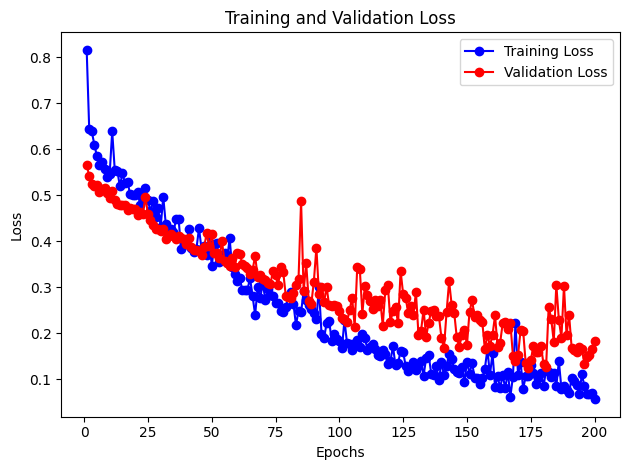

In [15]:

# # Plot accuracy
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
# plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# Plot loss
# plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()